## The targeting algorithm of CRPropa

Here we will introduce you to the targeting algorithm in CRPropa, which emits particles from their sources using a von-Mises-Fisher distribution instead of an isotropic distribution. After emission from their sources, the particles get a weight assigned to them so that the resulting distribution at the observer can be reweighted to resemble an isotropically emitted distribution from the sources. This can lead to significantly larger number of hits compared with starting with an isotropic emission.

### A simple example on how to use the targeting algorithm of CRPropa

In [1]:
import numpy as np
from crpropa import *

# Create a random magnetic-field setup
randomSeed = 42
turbSpectrum = SimpleTurbulenceSpectrum(0.2*nG, 200*kpc, 2*Mpc, 5./3.)
gridprops = GridProperties(Vector3d(0), 256, 100*kpc)
BField = SimpleGridTurbulence(turbSpectrum, gridprops, randomSeed)

# Cosmic-ray propagation in magnetic fields without interactions
sim = ModuleList()
sim.add(PropagationCK(BField))
sim.add(MaximumTrajectoryLength(25 * Mpc))

# Define an observer
sourcePosition = Vector3d(2., 2., 2.) * Mpc
obsPosition = Vector3d(2., 10., 2.) * Mpc
obsRadius = 2. * Mpc

obs = Observer()
obs.add(ObserverSurface( Sphere(obsPosition, obsRadius)))
obs.setDeactivateOnDetection(True)
FilenameObserver = 'TargetedEmission.txt'
output = TextOutput(FilenameObserver)
obs.onDetection(output)
sim.add(obs)
    
# Define the vMF source
source = Source()
source.add(SourcePosition(sourcePosition))
source.add(SourceParticleType(nucleusId(1,1)))
source.add(SourceEnergy(10. * EeV))

# Here we need to add the vMF parameters
mu = np.array([0.,1.,0.]) # The average direction emission, pointing from the source to the observer
muvec = Vector3d(float(mu[0]), float(mu[1]), float(mu[2]))
kappa = 100. # The concentration parameter, set to a relatively large value
nparticles = 100000

source.add(SourceDirectedEmission(muvec,kappa))

#now we run the simulation
sim.setShowProgress(True)
sim.run(source, nparticles)
output.close()

### Plotting of the results

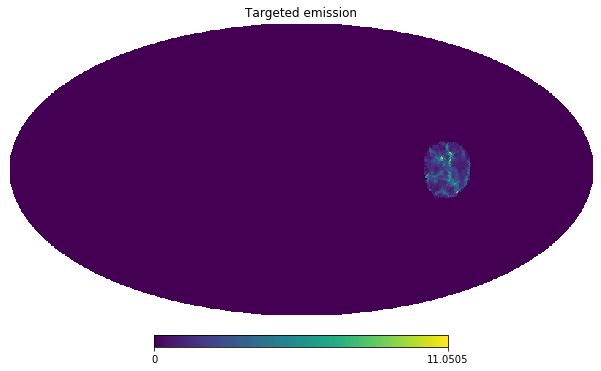

In [2]:
import healpy as hp
import matplotlib.pylab as plt

crdata = np.genfromtxt('TargetedEmission.txt')
Id = crdata[:,3]
E = crdata[:,4] * EeV
px = crdata[:,8]
py = crdata[:,9]
pz = crdata[:,10]
w = crdata[:,29]
lons = np.arctan2(-1. * py, -1. *px)
lats = np.pi / 2 - np.arccos( -pz / np.sqrt(px*px + py*py+ pz*pz) )

M = ParticleMapsContainer()
for i in range(len(E)):
    M.addParticle(int(Id[i]), E[i], lons[i], lats[i], w[i])

#stack all maps
crMap = np.zeros(49152)
for pid in M.getParticleIds():
    energies = M.getEnergies(int(pid))
    for i, energy in enumerate(energies):
        crMap += M.getMap(int(pid), energy * eV )

#plot maps using healpy
hp.mollview(map=crMap, title='Targeted emission')
plt.show()

### A learning algorithm to obtain optimal values for mu and kappa

In [3]:
import numpy as np
from crpropa import *
import os.path
import time

def run_batch(mu,kappa,nbatch,epoch):
    # Setup new batch simulation
    def run_sim(mu,kappa,nbatch,epoch):
        sim = ModuleList()
        sim.add( SimplePropagation(5.*parsec, 0.5*Mpc) )
        sim.add(MaximumTrajectoryLength(2000.*Mpc))

        sourcePosition = Vector3d(100., 0., 0.) * Mpc
        obsPosition = Vector3d(0., 0., 0.) * Mpc

        obs = Observer()
        obs.add(ObserverSurface( Sphere(sourcePosition, 50. * parsec)))
        obs.setDeactivateOnDetection(False)
        FilenameSource = 'SourceEmission_'+str(epoch)+'.txt'
        output1 = TextOutput(FilenameSource)
        obs.onDetection(output1)
        sim.add(obs)

        obs2 = Observer()
        obs2.add(ObserverSurface( Sphere(obsPosition, 10.*Mpc)))
        obs2.setDeactivateOnDetection(True)
        FilenameObserver = 'Observer_'+str(epoch)+'.txt'
        output2 = TextOutput(FilenameObserver)
        obs2.onDetection(output2)
        sim.add(obs2)
    
        # Define the vMF source
        source = Source()
        source.add(SourcePosition(sourcePosition))
        source.add(SourceParticleType(nucleusId(1,1)))
        source.add(SourceEnergy(1 * EeV))
    
        # Here we need to add the vMF parameters
        muvec = Vector3d(float(mu[0]), float(mu[1]), float(mu[2]))
        source.add(SourceDirectedEmission(muvec,kappa))
        
        # Now we run the simulation
        sim.setShowProgress(True)
        sim.run(source, nbatch)
        output1.close()
        output2.close()
        
    run_sim(mu,kappa,nbatch,epoch)    
    
    # Get ids of particles hitting the source
    while not os.path.exists('Observer_'+str(epoch)+'.txt'):
        time.sleep(1)
    idhit = np.loadtxt('Observer_'+str(epoch)+'.txt', usecols=(2), unpack=True)
    
    # Get emission directions of particles
    virtualfile = open('SourceEmission_'+str(epoch)+'.txt')
    ids, px,py,pz = np.loadtxt(virtualfile, usecols=(2,8,9,10), unpack=True) #, skiprows=10)
    
    indices = [np.where(ids==ii)[0][0] for ii in idhit]
    
    x=np.array([px[indices],py[indices],pz[indices]]).T

    return x
    

def pdf_vonMises(x,mu,kappa):
    # See eq. (3.1) of PoS (ICRC2019) 447
    res=kappa*np.exp(-kappa*(1-x.dot(mu)))/(2.*np.pi*(1.-np.exp(-2*kappa)))
    return res

def weight(x,mu,kappa):
    # This routine calculates the reweighting for particles that should have been emitted according to 4pi
    p0=1./(4.*np.pi)
    p1=pdf_vonMises(x,mu,kappa)
    res = p0/p1 
    return res

def estimate_mu_kappa(x,weights,probhit=0.9):
    # This is a very simple learning algorithm
    
    #1) Just estimate the mean direction on the sky 
    aux = np.sum(np.array([x[:,0]*weights,x[:,1]*weights,x[:,2]*weights]),axis=1)
    mu=aux/np.linalg.norm(aux) #NOTE: mu needs to be normalized
    
    #2) Estimate the disc of the target on the emission sky
    aux = np.sum(((x[:,0]*mu[0])**2+(x[:,1]*mu[1])**2+(x[:,2]*mu[2])**2)*weights)/np.sum(weights)
    
    # Estimate kappa, such that on average the hit probability is probhit
    kappa = np.log(1.-probhit)/(aux-1.) 
    
    return mu,kappa

def sample(mu,kappa,nbatch=100,probhit=0.9,nepoch=200):
    batches_x=[]
    batches_w=[]
    mu_traj=[]
    kappa_traj=[]
    acceptance=[]
    for e in np.arange(nepoch):
        print('Processing epoch Nr.:',e)
        
        # Run CRPropa to generate a batch of particles
        # CRPropa passes the initial normalised emission directions x
        print('starting simulation...')
        y=run_batch(mu,kappa,nbatch,e)
        print('simulation done...')
        
        # Now calculate weights for the particles
        weights = []
        for xx in y:
            weights.append(weight(xx,mu,kappa))
        
        # Change lists to arrays
        y       = np.array(y)
        weights = np.array(weights)
        
        # Learn the parameters of the emission vMF distribution
        mu,kappa=estimate_mu_kappa(y,weights,probhit=probhit)
        acceptance.append(len(y)/float(nbatch))
        mu_traj.append(mu)
        kappa_traj.append(kappa)
        
        batches_x.append(y)
        batches_w.append(weights)
        
        
    x = np.copy(batches_x[0])
    w = np.copy(batches_w[0])
    
    for i in np.arange(1, len(batches_w)):
        x=np.append(x, batches_x[i], axis=0)
        w=np.append(w, batches_w[i], axis=0)
        
        
    return x,w,np.array(acceptance),np.array(mu_traj),np.array(kappa_traj)


In [4]:
# Set initial values
mu    = np.array([1,0,0])
kappa = 0.00001 # We start with an almost 4pi kernel
Phit  = 0.90 # Here we choose the desired hit probability. Note: it is a trade off between accuracy and exploration

# Start the learning algorithm
x,w,acceptance, mu_traj, kappa_traj = sample(mu,kappa,probhit=Phit,nbatch=100000,nepoch=4)
print(mu_traj)
print(kappa_traj)

Processing epoch Nr.: 0
starting simulation...
simulation done...
Processing epoch Nr.: 1
starting simulation...
simulation done...
Processing epoch Nr.: 2
starting simulation...
simulation done...
Processing epoch Nr.: 3
starting simulation...
simulation done...
[[-9.99977342e-01  6.51613821e-03 -1.68982226e-03]
 [-9.99999983e-01  7.11244300e-06  1.84893357e-04]
 [-9.99999990e-01  1.19974426e-05  1.38933688e-04]
 [-9.99999849e-01  3.93475813e-04 -3.82886251e-04]]
[464.32730192 458.36995118 459.55750364 459.07788569]


### Testing sampling results

As can be seen in the following plot, the average sampling efficiency matches the desired hitting probability Phit:

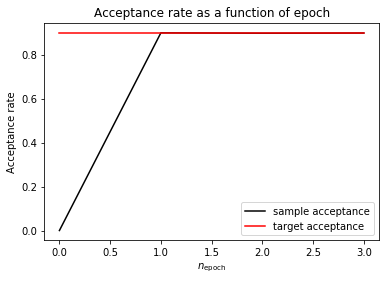

In [5]:
import matplotlib.pylab as plt

plt.title('Acceptance rate as a function of epoch')
plt.plot(acceptance, label='sample acceptance',color='black')
plt.plot(acceptance*0+Phit, label='target acceptance',color='red')
plt.xlabel(r'$n_{\rm{epoch}}$')
plt.ylabel('Acceptance rate')
plt.legend()
plt.show()